In [126]:
import numpy as np
import random as rnd
import math

from matplotlib import pyplot as plt
from matplotlib.colors import ListedColormap

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.datasets import make_circles
from sklearn import svm

In [127]:
def plot_decision_regions(X, y, classifier, resolution=0.02):
    
    # setup marker generator and color map
    markers = ('s', 'x', 'o', '^', 'v')
    colors = ('red', 'blue', 'lightgreen', 'gray', 'cyan')
    cmap = ListedColormap(colors[:len(np.unique(y))])
    
    # plot the decision surface
    x1_min, x1_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    x2_min, x2_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx1, xx2 = np.meshgrid(np.arange(x1_min, x1_max, resolution), np.arange(x2_min, x2_max, resolution))
    
    Z = classifier.predict(np.array([xx1.ravel(), xx2.ravel()]).T)
    Z = Z.reshape(xx1.shape)
    
    plt.contourf(xx1, xx2, Z, alpha=0.4, cmap=cmap)
    plt.xlim(xx1.min(), xx1.max())
    plt.ylim(xx2.min(), xx2.max())
    
    # plot class samples
    for idx, cl in enumerate(np.unique(y)):
        plt.scatter(x=X[y == cl, 0], y=X[y == cl, 1], alpha=0.8, c=cmap(idx), marker=markers[idx], label=cl)

In [128]:
def generate_info(a=-10, b=10, param=1, N=2, size=1000):
    coefs = np.random.normal(0, 1, N - 1)
    
    X_1 = np.random.uniform(a, b, (size, N - 1))
    Y_1 = X_1.dot(coefs) + param + np.random.normal(0, 1, size)
    O_1 = np.ones(size, dtype=int)
    data_1 = np.column_stack((X_1, Y_1, O_1))
    
    X_2 = np.random.uniform(a, b, (size, N - 1))
    Y_2 = X_2.dot(coefs) - param + np.random.normal(0, 1, size)
    O_2 = (-1) * np.ones(size, dtype=int)
    data_2 = np.column_stack((X_2, Y_2, O_2))
    
    data = np.row_stack((data_1, data_2))
    np.random.shuffle(data)
    
    labels = data[:, N]
    data = np.delete(data, obj=N, axis=1)
    
    return (data, labels)

In [129]:
size = 200
a = -1
b = 1
param = 1
N = 2
data, labels = generate_info(a, b, param, N, size)

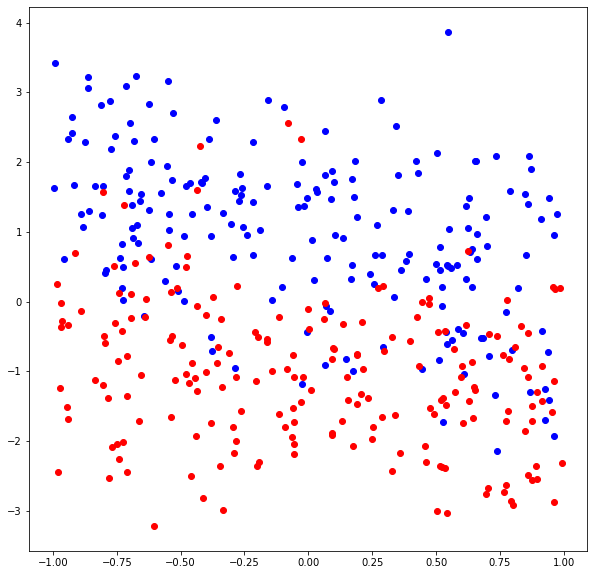

In [130]:
if N == 2:
    plt.figure(figsize=(10, 10))
    plt.scatter(data[labels == 1, 0], data[labels == 1, 1], color='blue')
    plt.scatter(data[labels != 1, 0], data[labels != 1, 1], color='red')
    plt.show()

In [131]:
X_train, X_test, y_train, y_test = train_test_split(data, labels, train_size=0.8)

In [132]:
skl_model = svm.SVC()
skl_model.fit(X_train, y_train)
skl_predicts = skl_model.predict(X_test)

# LinearSVM

In [133]:
class LinearSVM:
    """ 
        SVM for non linearly separable case. Works for linearly separable data
        Faster then casual SVM !!!
    """
    
    def __init__(self, alpha=1.0, n_epochs=10, eta=0.001):
        self.alpha = alpha
        self.n_epochs = n_epochs
        self.eta = eta
        self.w = None
        self.func_log = {}
    
    def fit(self, X_train, y_train):
        X = np.column_stack((X_train, np.ones((X_train.shape[0], ))))
        y = y_train
        
        self.w = np.random.normal(loc=0, scale=1, size=X.shape[1])
        self.func_log[0] = self.loss_func(X, y)
        for epoch in range(self.n_epochs):
            for i, x in enumerate(X):
                if self.hinge_loss(x, y[i]) > 0:
                    self.w = self.w - self.eta * (-1 * y[i] * x)
            self.func_log[epoch + 1] = self.loss_func(X, y)
            
    def hinge_loss(self, x, y):
        value = max(0, 1 - y * np.dot(self.w, x))
        return value
    
    def loss_func(self, X_data, y_data):
        value = 0.5 * np.dot(self.w, self.w)
        for i in range(X_data.shape[0]):
            value += self.hinge_loss(X_data[i], y_data[i])
        return value  
    
    def predict(self, X_test):
        X = np.column_stack((X_test, np.ones((X_test.shape[0], ))))
        labels = np.dot(X, self.w)
        return np.where(labels > 0, 1, -1)

In [134]:
My_LinearSVM = LinearSVM(alpha=20_000, n_epochs=100, eta=0.1)
My_LinearSVM.fit(X_train, y_train)
my_predicts = My_LinearSVM.predict(X_test)

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


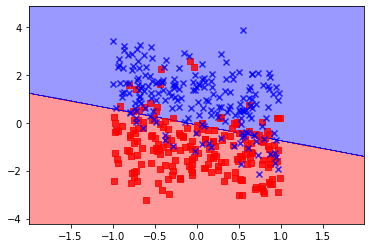

In [135]:
if N == 2:
    plot_decision_regions(data, labels, My_LinearSVM)

In [136]:
print('My LinearSVM accuracy = {:.5f}'.format(accuracy_score(my_predicts, y_test)))
print('Sklearn SVM accuracy = {:.5f}'.format(accuracy_score(skl_predicts, y_test)))

My LinearSVM accuracy = 0.88750
Sklearn SVM accuracy = 0.86250


# Convex SVM

In [137]:
class SVM:
    """ 
        Solve the convex programming task
    """
    
    def __init__(self, rate, C=50_000, iters=None, kernel='linear', gamma=0.5, degree=3, R=1):
        self.rate = rate
        self.C = C
        self.iters = iters
        self.gamma = gamma
        self.degree = degree
        self.R = R
        
        self.support_vectors = None
        self.support_y = None
        self.lambdas = None
        
        if kernel == 'rbf':
            self.kernel_func = self.rbf_kernel
        elif kernel == 'poly':
            self.kernel_func = self.poly_kernel
        elif kernel == 'linear':
            self.kernel_func = self.linear_kernel
    
    def fit(self, X_train, y_train, eps=1e-10):
        """ 
            Fit the model
            It's necessary to find good RATE for convergence the function of quadric programming
        """
        self.iters = X_train.shape[0] * 1200 if self.iters is None else self.iters
        
        c_matrix = 0.5 * np.array([[self.kernel_func(x, z) for x in X_train] for z in X_train]) + 1
        c_matrix *= np.outer(y_train, y_train)
        
        lmbd = np.zeros((X_train.shape[0]))
        old_lmbd = lmbd + 1
        counter = 0
        
        while np.dot(lmbd - old_lmbd, lmbd - old_lmbd) > eps and counter <= self.iters:
            
            old_lmbd = lmbd
            counter += 1
            
            delta = 2 * np.dot(c_matrix, lmbd) - 1
            lmbd = lmbd - self.rate * delta
            lmbd = np.where(lmbd > 0, lmbd, 0)
            lmbd = np.where(lmbd < self.C, lmbd, self.C)
        
              
        indexes = np.array([i for i in range(X_train.shape[0]) if lmbd[i] > 0])
        self.lambdas, self.support_vectors, self.support_y = (lmbd[lmbd > 0], X_train[lmbd > 0], y_train[lmbd > 0])
        
        self.b = 0
        for j in range(self.lambdas.shape[0]):
            for i in range(self.lambdas.shape[0]):
                tmp_value = self.kernel_func(self.support_vectors[i], self.support_vectors[j])
                self.b += self.lambdas[i] * self.support_y[i] * tmp_value 
        
        self.b = (sum(self.support_y) - self.b) / len(self.support_y)
            
    def predict(self, X):
        labels = np.zeros(X.shape[0])
        for j in range(X.shape[0]):
            label = self.b
            label += sum(np.array([self.lambdas[i] * self.support_y[i] * self.kernel_func(X[j], self.support_vectors[i])
                                 for i in range(self.lambdas.shape[0])]))
            labels[j] = label
        
        return np.where(labels > 0, 1, -1)
    
    def rbf_kernel(self, x, z):
        return math.exp(-1 * self.gamma * np.dot(x - z, x - z))
    
    def poly_kernel(self, x, z):
        return (np.dot(x, z) + self.R) ** self.degree
    
    def linear_kernel(self, x, z):
        return np.dot(x, z)

In [138]:
My_SVM = SVM(rate=0.001, kernel='poly')
My_SVM.fit(X_train, y_train)
my_predicts = My_SVM.predict(X_test)

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


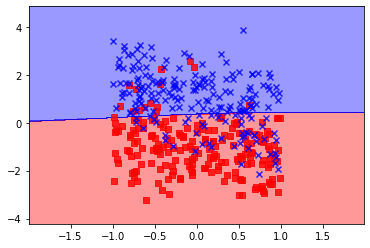

In [139]:
if N == 2:
    plot_decision_regions(data, labels, My_SVM)

In [140]:
print('My SVM accuracy = {:.5f}'.format(accuracy_score(my_predicts, y_test)))
print('Sklearn SVM accuracy = {:.5f}'.format(accuracy_score(skl_predicts, y_test)))

My SVM accuracy = 0.83750
Sklearn SVM accuracy = 0.86250


# Kernel Trick

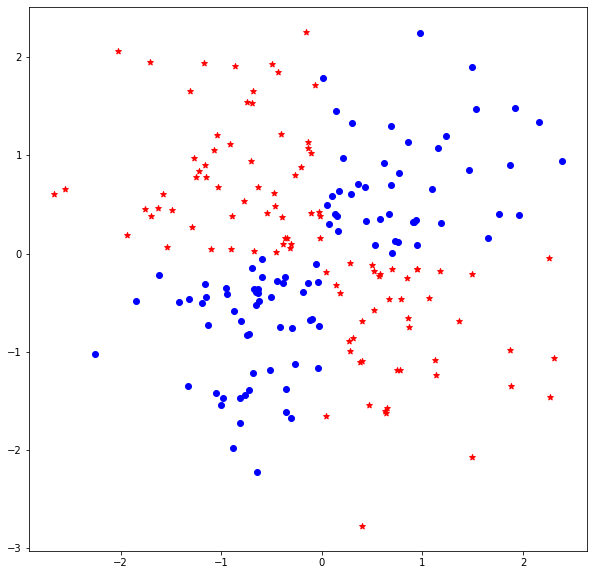

In [141]:
np.random.seed(0)
X = np.random.randn(size, 2)
y = np.logical_xor(X[:, 0] > 0, X[:, 1] > 0)
y = np.where(y, 1, -1)

plt.figure(figsize=(10, 10))
plt.scatter(X[y == 1, 0], X[y == 1, 1], marker='*', color='red')
plt.scatter(X[y != 1, 0], X[y != 1, 1], marker='o', color='blue')
plt.show()

In [142]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8)

In [143]:
skl_model = svm.SVC()
skl_model.fit(X_train, y_train)
skl_predicts = skl_model.predict(X_test)

In [144]:
Kernel_SVM = SVM(rate=0.001, kernel='rbf')
Kernel_SVM.fit(X_train, y_train)
kernel_predicts = Kernel_SVM.predict(X_test)

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


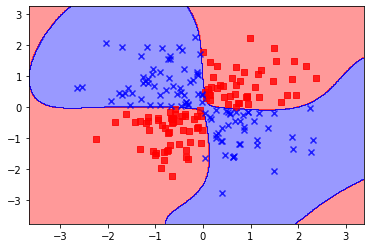

In [145]:
plot_decision_regions(X, y, Kernel_SVM)

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


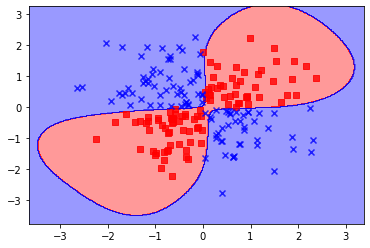

In [146]:
plot_decision_regions(X, y, skl_model)

In [147]:
print('My SVM accuracy = {:.5f}'.format(accuracy_score(kernel_predicts, y_test)))
print('Sklearn SVM accuracy = {:.5f}'.format(accuracy_score(skl_predicts, y_test)))

My SVM accuracy = 0.97500
Sklearn SVM accuracy = 0.97500


# Circles

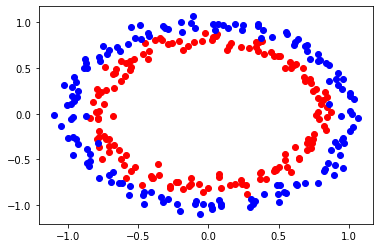

In [148]:
X, y = make_circles(n_samples=300, noise=0.05)
y = np.where(y > 0, 1, -1)

plt.scatter(X[y == 1, 0], X[y == 1, 1], color='red')
plt.scatter(X[y != 1, 0], X[y != 1, 1], color='blue')
plt.show()

In [149]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8)

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


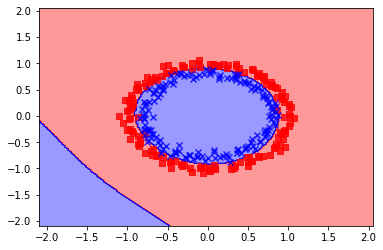

In [150]:
Kernel_SVM = SVM(rate=0.001, kernel='poly')
Kernel_SVM.fit(X_train, y_train)
kernel_predicts = Kernel_SVM.predict(X_test)
plot_decision_regions(X, y, Kernel_SVM)

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


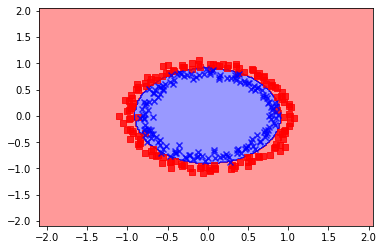

In [151]:
skl_model = svm.SVC(kernel='poly', degree=4)
skl_model.fit(X_train, y_train)
skl_predicts = skl_model.predict(X_test)
plot_decision_regions(X, y, skl_model)

In [152]:
print('My SVM accuracy = {:.5f}'.format(accuracy_score(kernel_predicts, y_test)))
print('Sklearn SVM accuracy = {:.5f}'.format(accuracy_score(skl_predicts, y_test)))

My SVM accuracy = 0.95000
Sklearn SVM accuracy = 0.93333
